# Example to plot map



In this example, we will plot the provided map as well as the localization results.
The map is stored as a bitmap image with a specific pixel-per-meter scale.

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataname = "1"

bitmap_filename = "map/miraikan_5.bmp"
traj_filename = f"ground_truth/{dataname}.csv"

### Data load

Load the bitmap and scale to 0-1. Also define specs of the map


In [3]:
bitmap_array = np.array(Image.open(bitmap_filename))/255.0

map_origin=(-5.625, -12.75)
map_ppm = 100 # pixels per meter

Load a ground-truth data to plot. It contains location and orientation. As we are gonig to use yaw angle (rotation around z axis), we also convert the quaternins to yaw angles.

In [4]:
def quaternion_to_yaw(qw, qx, qy, qz):
    return np.arctan2(2.0 * (qw * qz + qx * qy), 1.0 - 2.0 * (qy * qy + qz * qz))

df_traj = pd.read_csv(traj_filename, header=0).astype(float)

display(df_traj)

df_traj['yaw'] = quaternion_to_yaw(df_traj['qw'], df_traj['qx'], df_traj['qy'], df_traj['qz'])

,timestamp,x,y,z,qw,qx,qy,qz
0,0.000,41.908298,-10.167844,1.086074,0.620845,0.391461,0.451081,0.507776
1,0.067,41.894479,-10.144016,1.089935,0.625199,0.377639,0.443265,0.519645
2,0.167,41.894543,-10.146287,1.088108,0.621363,0.378608,0.448350,0.519179
3,0.300,41.890515,-10.143397,1.097090,0.613394,0.384823,0.446430,0.525699
4,0.434,41.891810,-10.136658,1.095929,0.617561,0.381556,0.446253,0.523347
...,...,...,...,...,...,...,...,...
6268,826.925,41.449481,-10.043877,1.089705,0.722649,0.584273,-0.144962,-0.339689
6269,827.025,41.489190,-10.073789,1.080488,0.716057,0.602505,-0.099877,-0.338045
6270,827.092,41.423673,-9.999193,1.062517,0.720921,0.595851,-0.113906,-0.335052
6271,827.192,41.424420,-10.007831,1.068319,0.718073,0.599907,-0.118537,-0.332313


### Plot trajectory

Let's plot them together.

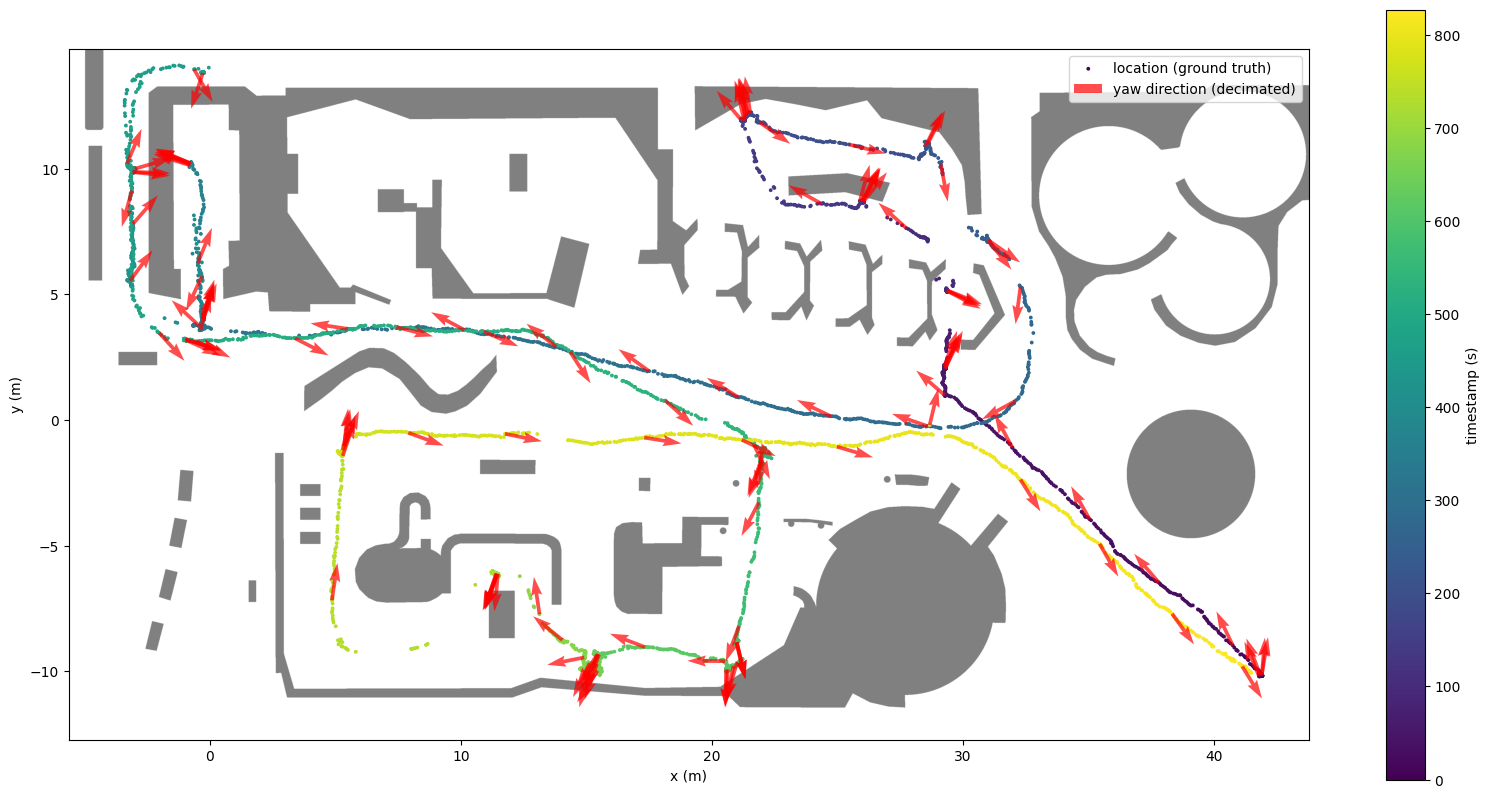

In [5]:
def plot_map(ax, bitmap, map_origin, map_ppm):
    height, width = bitmap.shape[:2]
    
    # Calculate extent in meters
    width_m = width / map_ppm
    height_m = height / map_ppm
    
    extent = [
        map_origin[0],                    # left (x_min)
        map_origin[0] + width_m,          # right (x_max)
        map_origin[1],                    # bottom (y_min)
        map_origin[1] + height_m          # top (y_max)
    ]
    
    ax.imshow(bitmap, extent=extent, alpha=0.5, cmap='gray')
    
    
def plot_yaw(ax, df_traj, decimation_rate=1):
    decimated_df = df_traj.iloc[::decimation_rate]
    arrow_length = 1.5
    dx = arrow_length * np.cos(decimated_df.yaw)
    dy = arrow_length * np.sin(decimated_df.yaw)

    ax.quiver(decimated_df.x, decimated_df.y, dx, dy, 
            angles='xy', scale_units='xy', scale=1, 
            color='red', alpha=0.7, width=0.003, label="yaw direction (decimated)")
    
    
fig, ax = plt.subplots(1,1,figsize=(20, 10))
plot_map(ax, bitmap_array, map_origin, map_ppm)

scatter = ax.scatter(df_traj.x, df_traj.y, c=df_traj.timestamp, s=3, label="location (ground truth)")

plot_yaw(ax, df_traj, decimation_rate=50)

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

plt.colorbar(scatter, ax=ax, label='timestamp (s)')
    
plt.legend()
plt.show()
